In [1]:
import torch as t
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision as tv
from torch.utils.data import DataLoader
from tqdm import tqdm 
from matplotlib.pyplot import *

In [15]:
transform=tv.transforms.transforms.ToTensor()
train_data = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data  = tv.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

trainloader = DataLoader(train_data, batch_size=128, shuffle= True, pin_memory=True)
testloader  = DataLoader(test_data, batch_size=128, shuffle=False)

Files already downloaded and verified


In [17]:
print(f'Total num of batch: {len(trainloader)}')
print(f'Each element contains: {len(next(iter(trainloader)))}')
print(f'Each batch images: {next(iter(trainloader))[0].shape} n_sample, channels, pixel, pixel')
print(f'Each batch labels: {next(iter(trainloader))[1].shape}')

Total num of batch: 391
Each element contains: 2
Each batch images: torch.Size([128, 3, 32, 32]) n_sample, channels, pixel, pixel
Each batch labels: torch.Size([128])


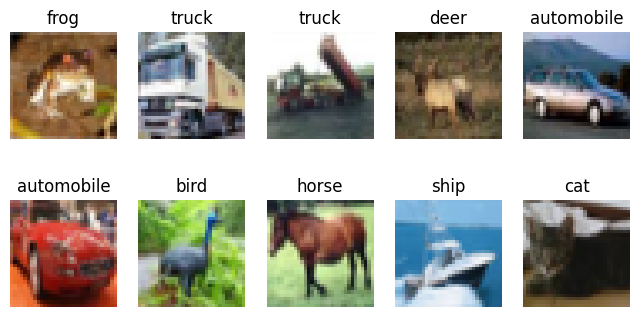

In [18]:
cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

data_iter=iter(testloader)
images, labels =next(data_iter)

fig, axes = subplots(2,5, figsize=(8,4))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.set_title(f'{cifar10_classes[labels[i].item()]}')
    ax.axis('off')
show();

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.cv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()          # separate ReLU
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.cv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu1(self.cv1(x))
        x = self.pool1(x)

        x = self.relu2(self.cv2(x))
        x = self.pool2(x) 

        x = self.relu3(self.cv3(x))
        x = self.pool3(x)
        
        x = x.flatten(start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Training

In [31]:
device = t.device("mps")
model1 = CNN().to(device)

t.mps.empty_cache()
n_epoch=20
optimizer=optim.Adam(model1.parameters(), lr=1e-3)
criterion=nn.CrossEntropyLoss()
batch_loss=[]

for epoch in range(n_epoch):
    model1.train()
    pgbar=tqdm(trainloader, desc=f"Epoch {epoch+1}/{n_epoch}", leave=True)
    running_loss=0.0

    for i, (images, labels) in enumerate(pgbar):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        ys=model1(images)
        loss=criterion(ys, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_loss.append(loss.item())
    
    print(f"Loss: {running_loss / len(trainloader):.4f}")
t.save(model1.state_dict(), "CIFAR10_model1.pth")

Epoch 1/20: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Loss: 1.5859


Epoch 2/20: 100%|██████████| 391/391 [00:31<00:00, 12.29it/s]


Loss: 1.1795


Epoch 3/20: 100%|██████████| 391/391 [00:25<00:00, 15.50it/s]


Loss: 0.9849


Epoch 4/20: 100%|██████████| 391/391 [00:26<00:00, 14.77it/s]


Loss: 0.8633


Epoch 5/20: 100%|██████████| 391/391 [00:25<00:00, 15.10it/s]


Loss: 0.7639


Epoch 6/20: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]


Loss: 0.6709


Epoch 7/20:   0%|          | 0/391 [00:00<?, ?it/s]


KeyboardInterrupt: 

## Load pretrained model1

In [39]:
model1 = CNN()  # Create model instance
model1.load_state_dict(t.load("CIFAR10_model1.pth"))
model1.to(device)  # Set to evaluation mode

CNN(
  (cv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

## eval

In [ ]:
import numpy as np
plot(range(len(trainloader)*n_epoch), np.array(batch_loss));

In [40]:
model1.eval()
correct = 0
total = 0
with t.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        _, predicted = t.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.14%


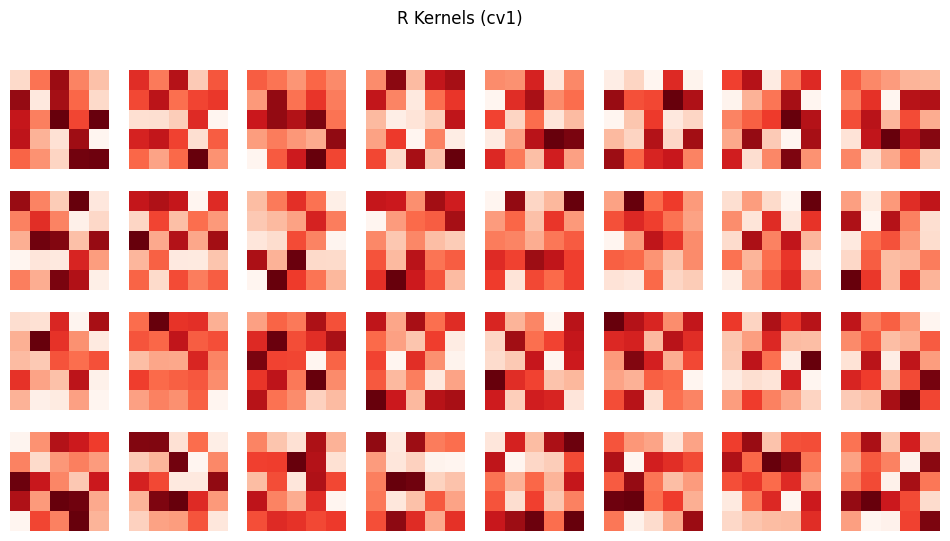

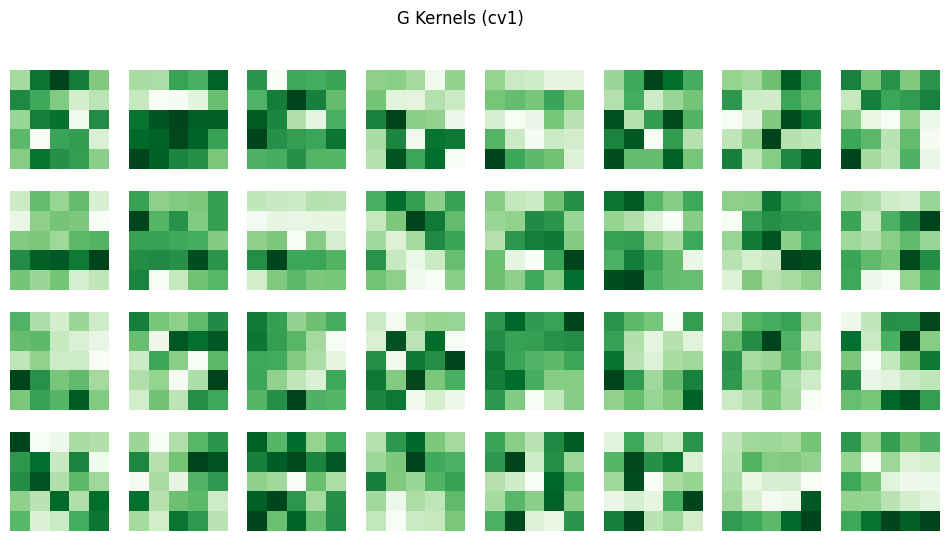

In [9]:
cv1_weights = model1.cv2.weight.data.cpu().numpy()  # Convert to NumPy

# Normalize weights for better visualization
cv1_weights = (cv1_weights - cv1_weights.min()) / (cv1_weights.max() - cv1_weights.min())

# Create a grid for visualization
num_kernels = cv1_weights.shape[0]  # Number of filters
fig, axes = subplots(4, 8, figsize=(12, 6)) 

for i, ax in enumerate(axes.flat):
    if i < num_kernels:
        kernel_red = cv1_weights[i, 0]  # Extract only the Red channel (index 0)
        ax.imshow(kernel_red, cmap='Reds')
        ax.axis("off")

suptitle("R Kernels (cv1)")

fig, axes = subplots(4, 8, figsize=(12, 6)) 

for i, ax in enumerate(axes.flat):
    if i < num_kernels:
        kernel_red = cv1_weights[i, 1]  # Extract only the Red channel (index 0)
        ax.imshow(kernel_red, cmap='Greens')
        ax.axis("off")

suptitle("G Kernels (cv1)")

show();


## $CV1~post-ReLU$

Processing: 100%|██████████| 391/391 [1:07:19<00:00, 10.33s/it]


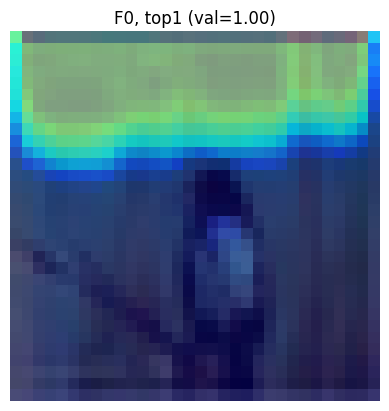

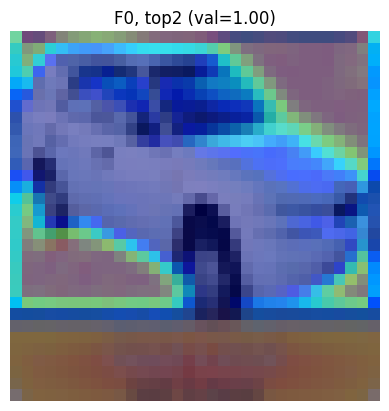

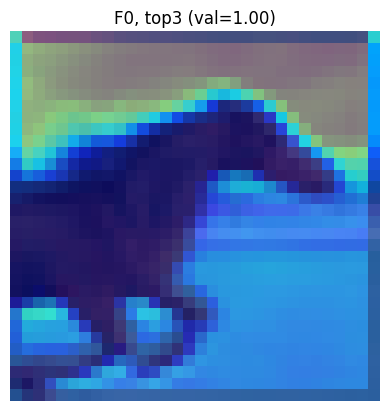

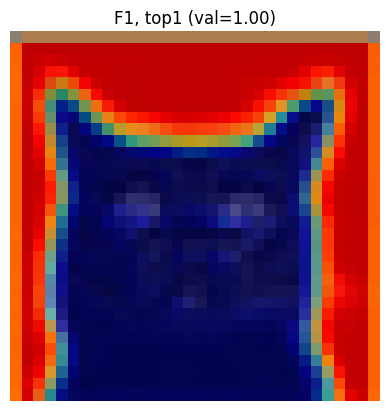

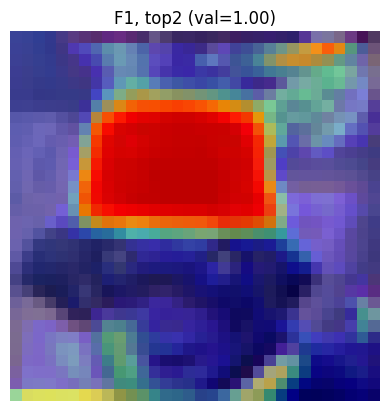

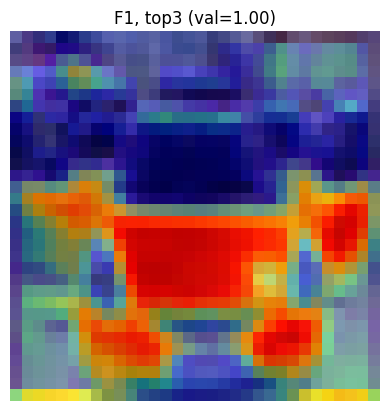

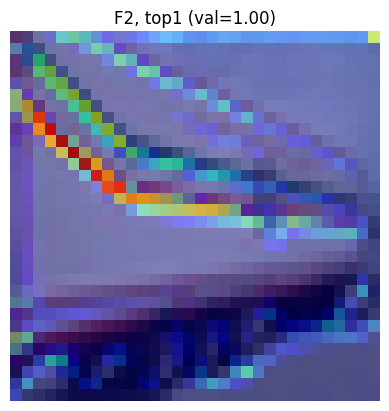

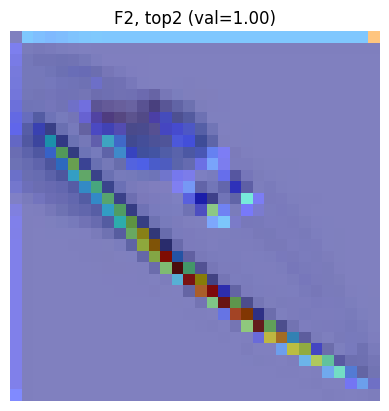

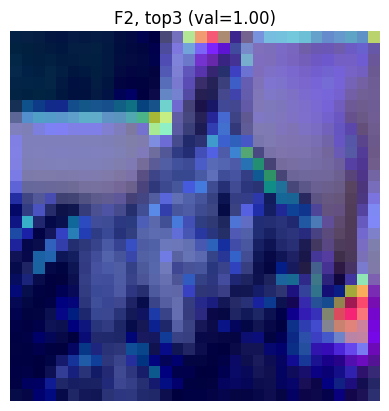

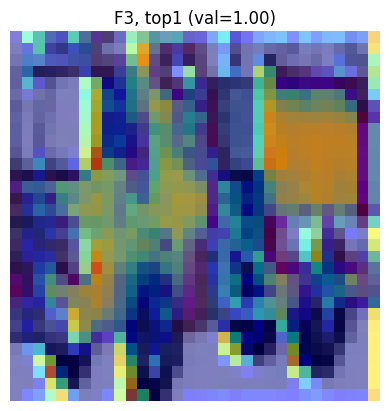

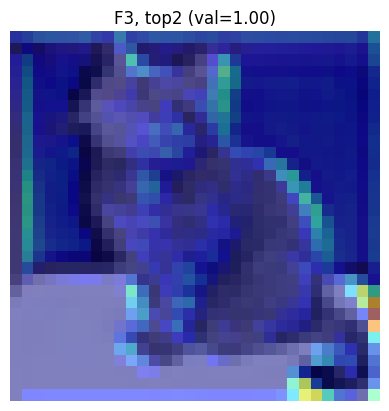

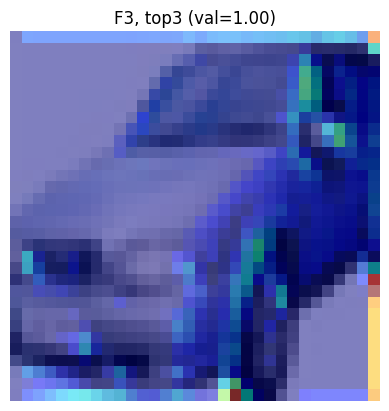

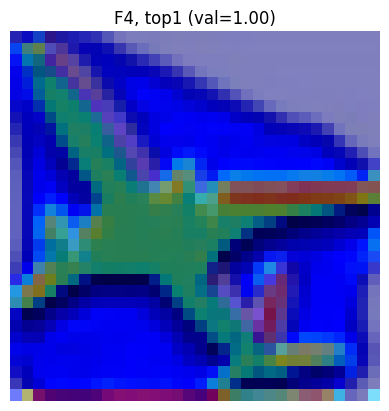

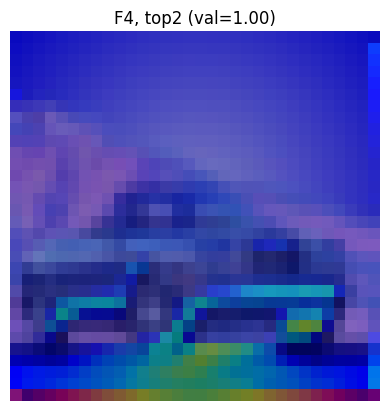

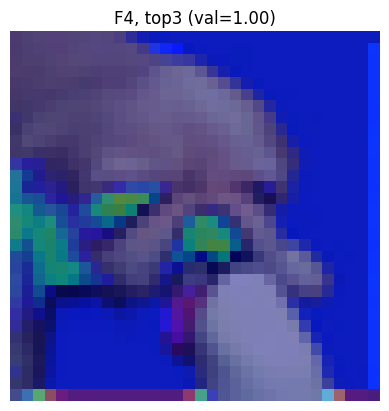

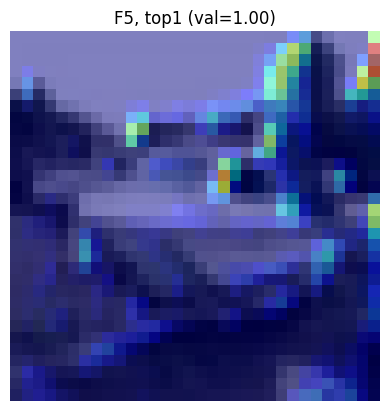

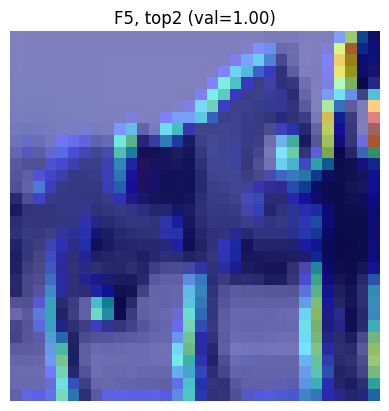

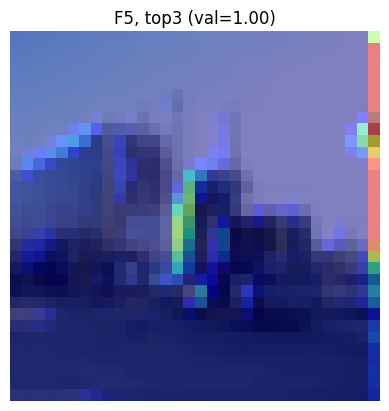

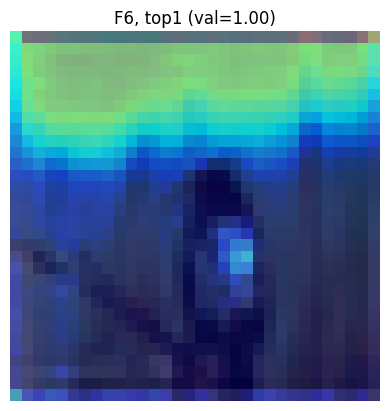

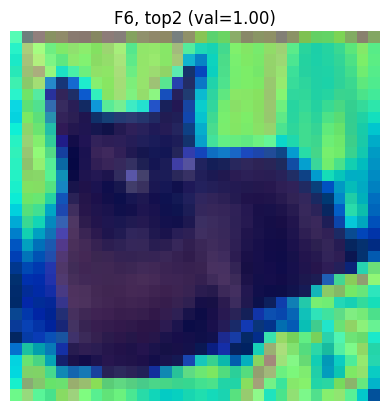

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12990a0c0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


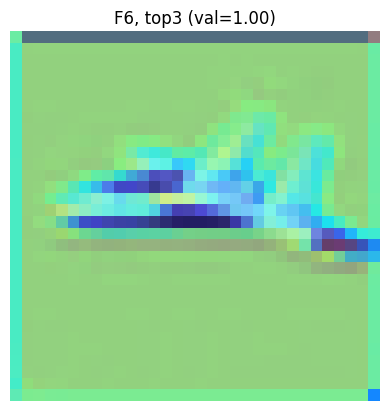

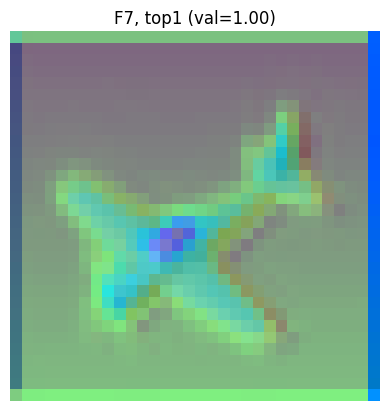

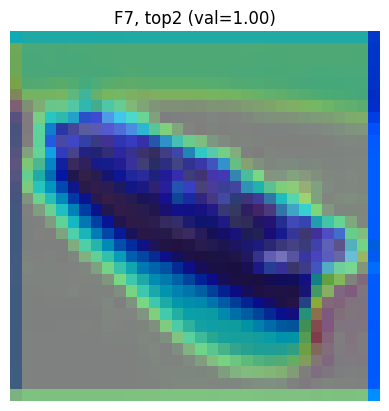

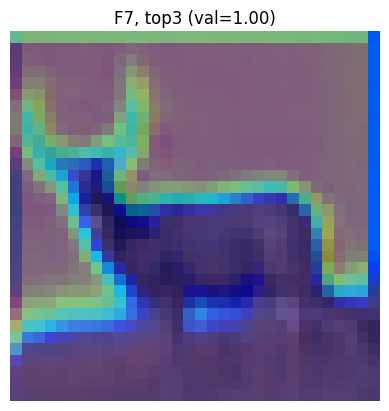

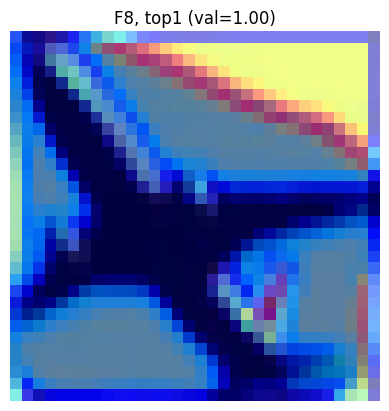

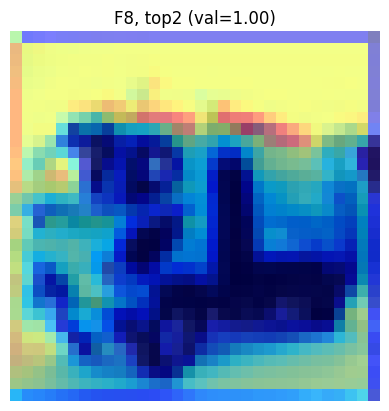

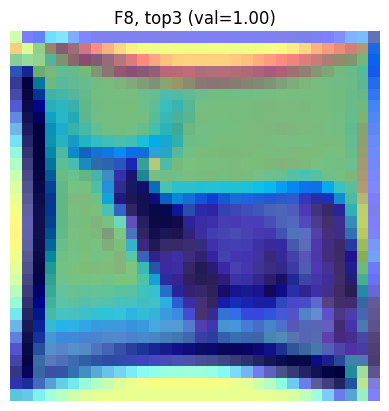

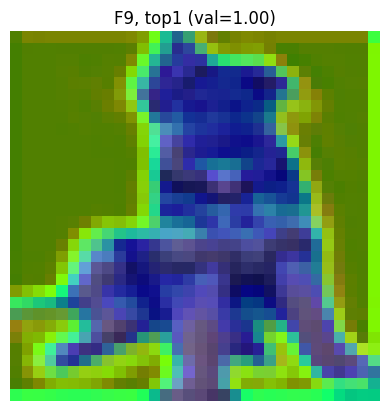

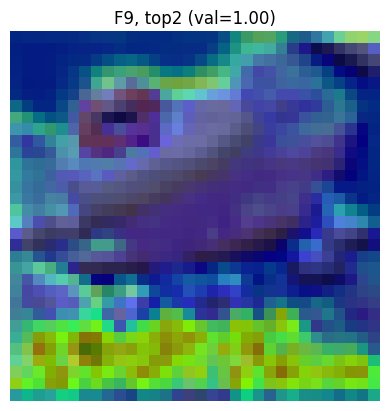

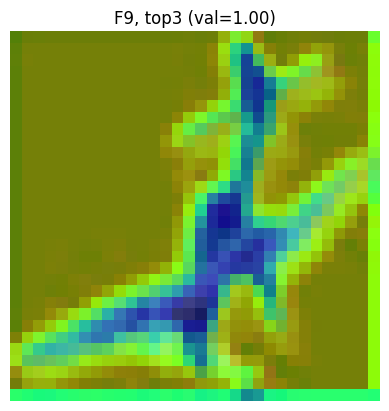

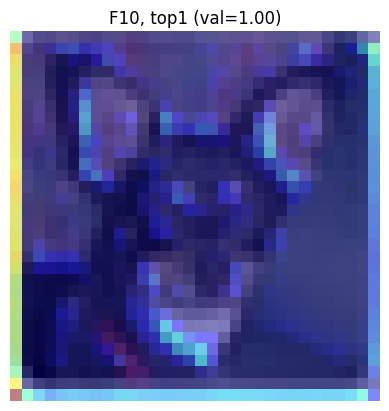

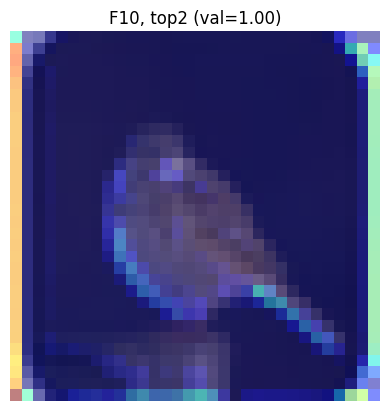

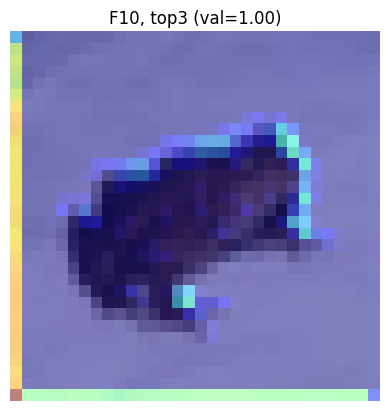

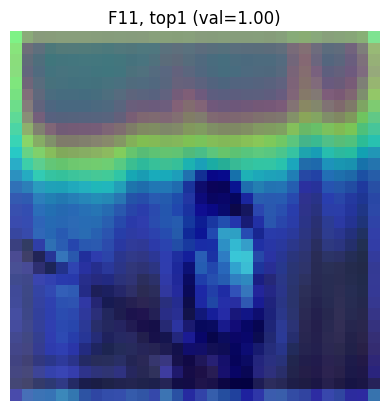

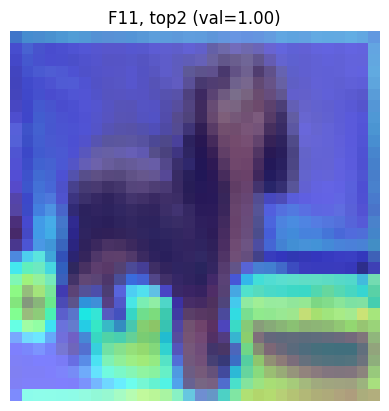

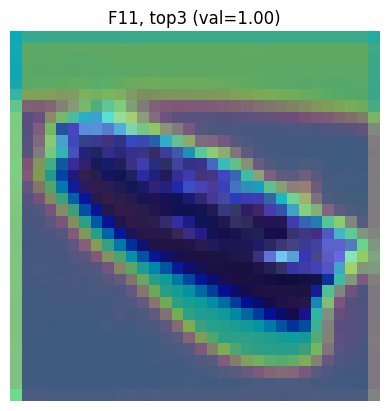

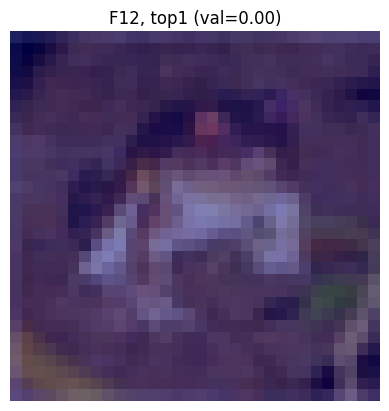

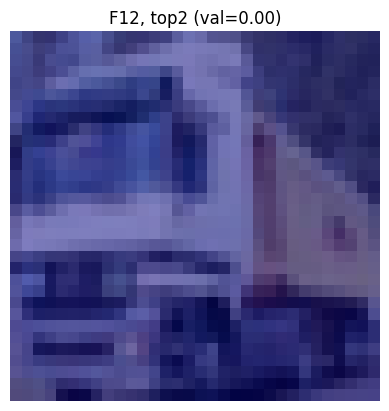

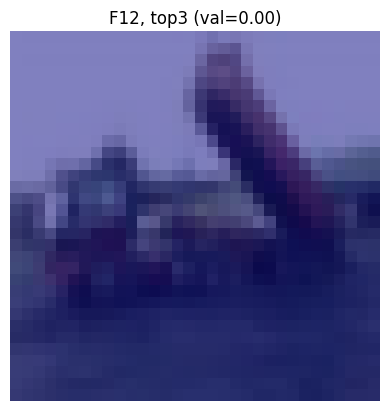

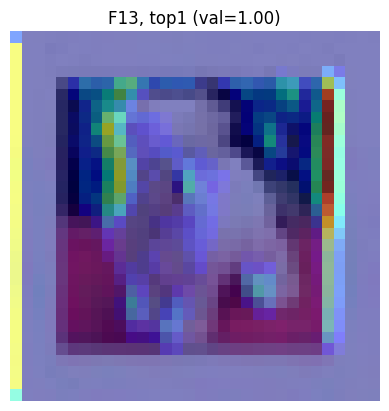

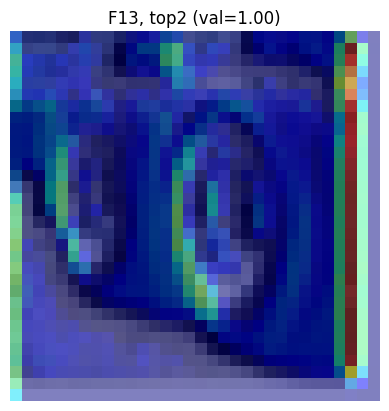

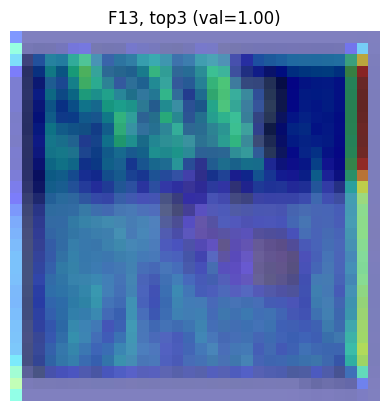

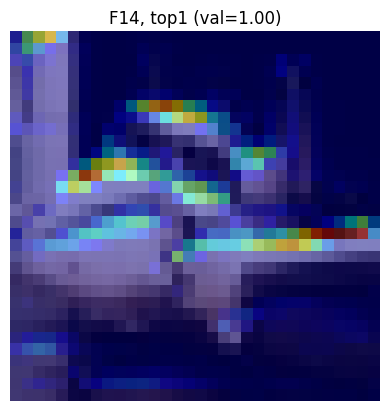

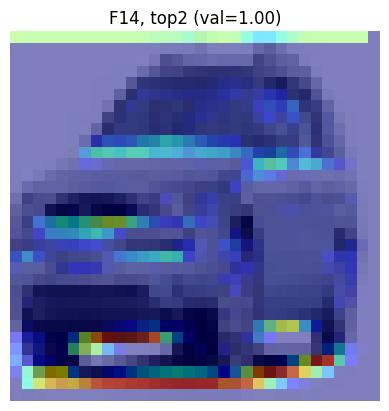

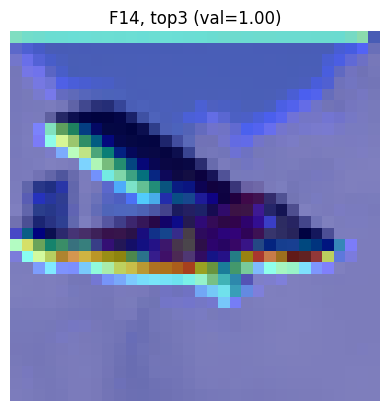

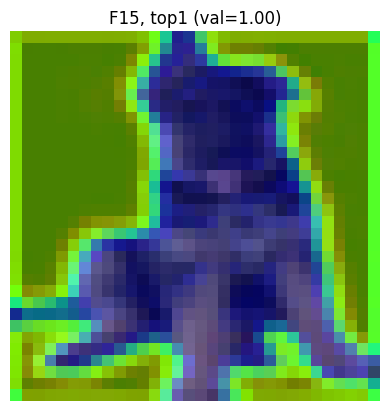

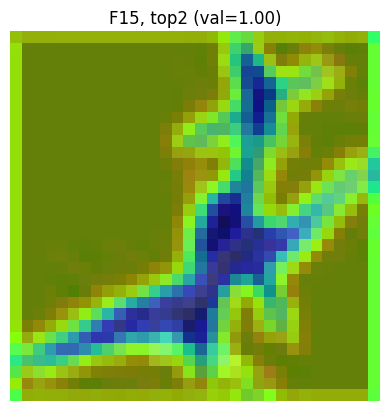

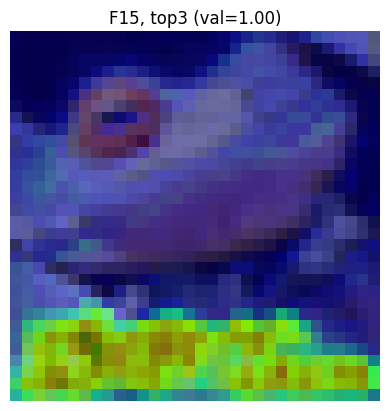

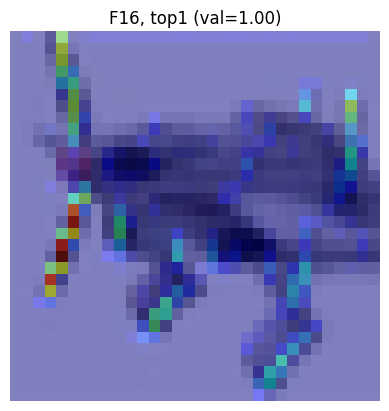

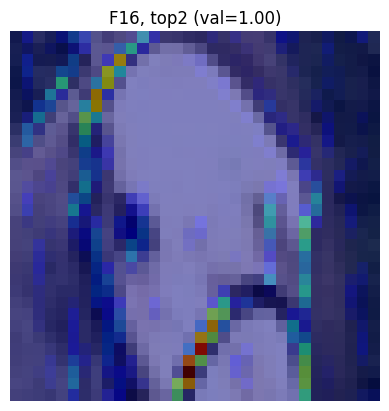

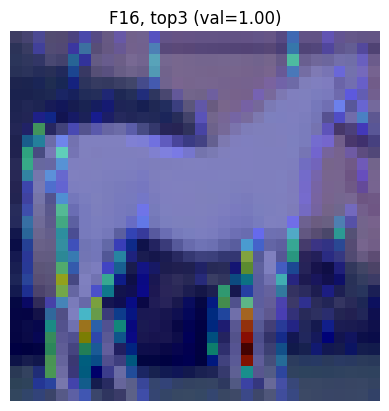

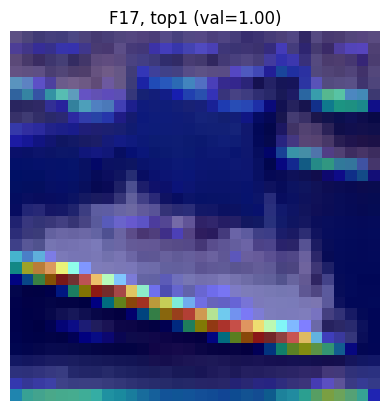

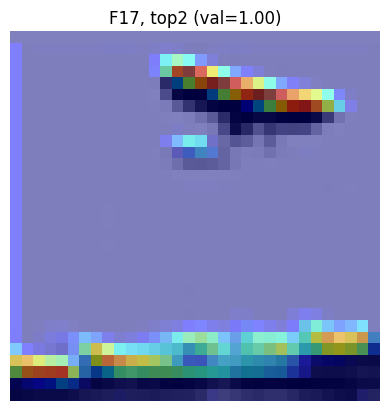

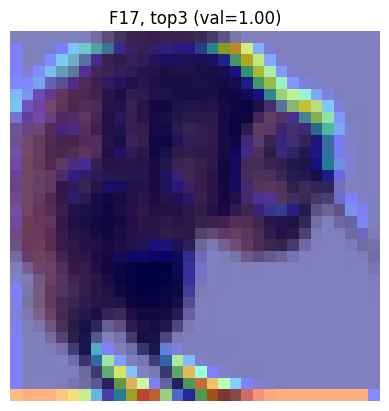

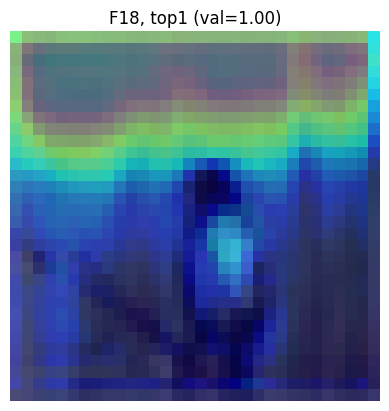

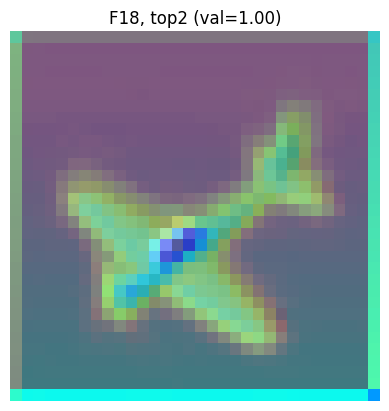

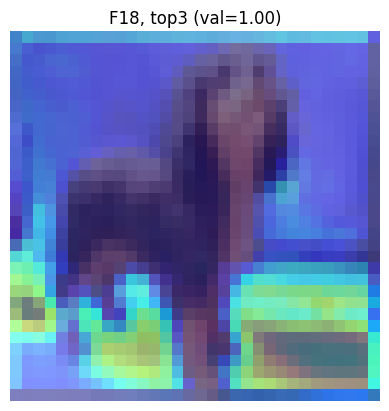

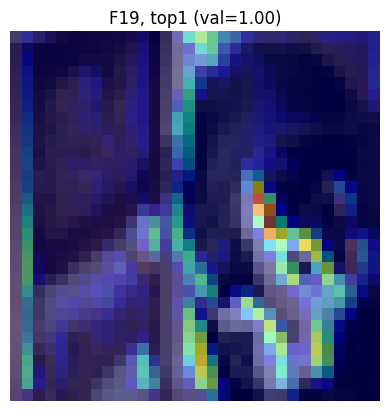

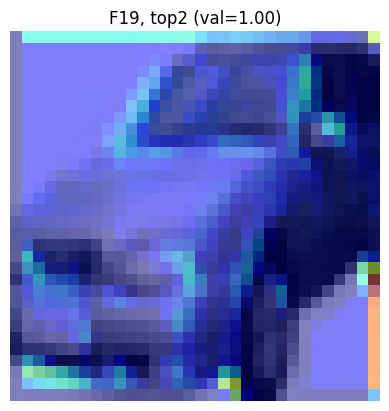

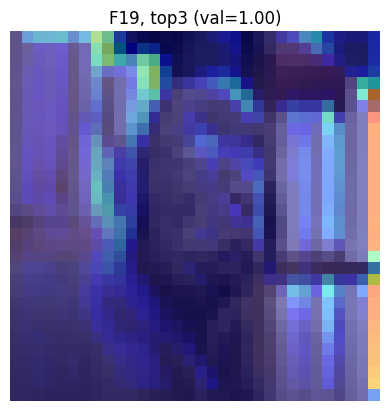

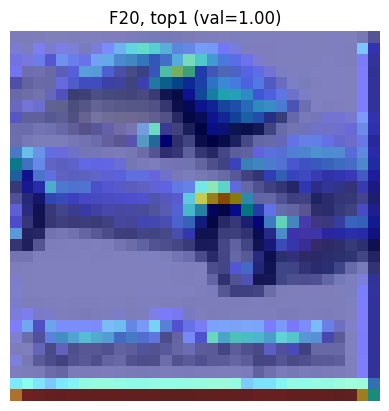

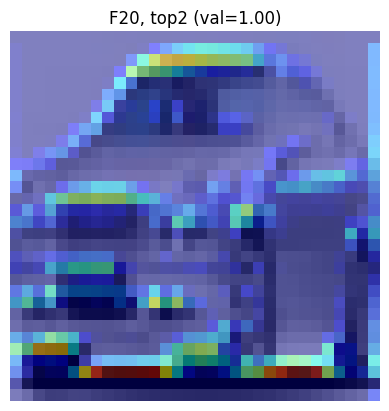

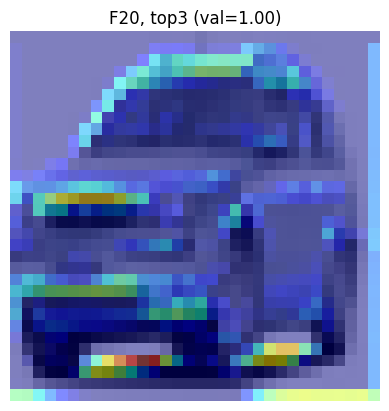

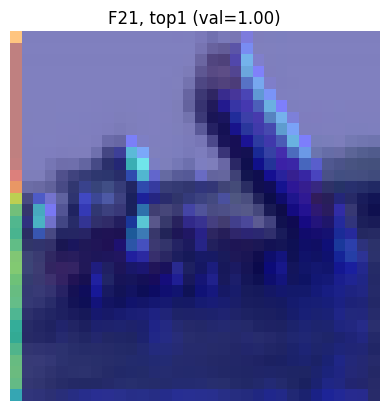

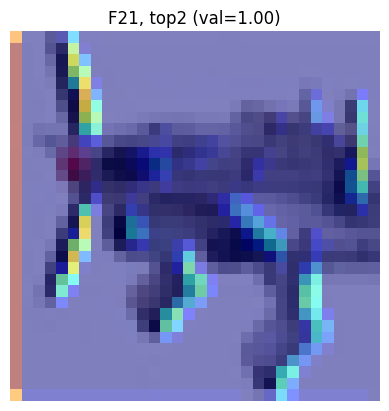

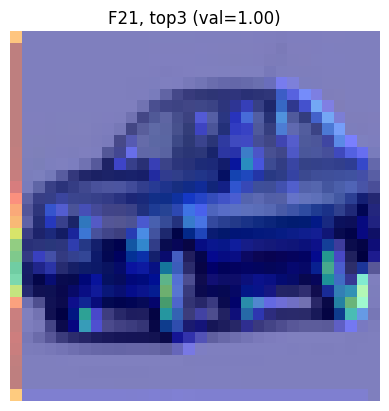

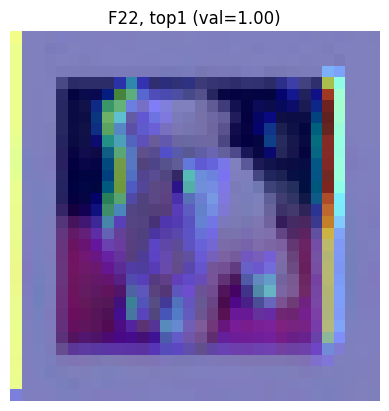

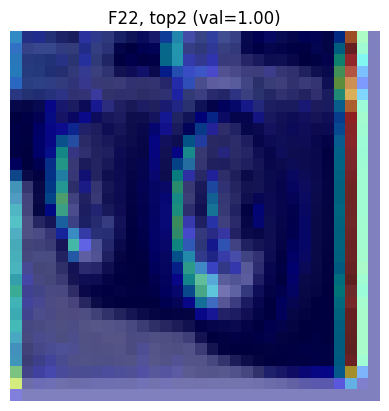

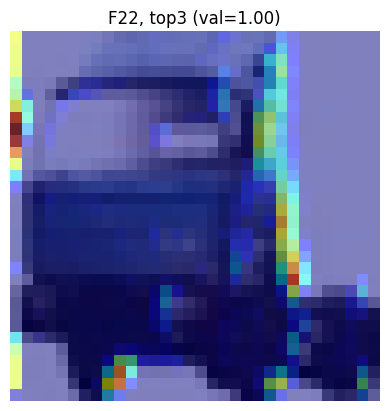

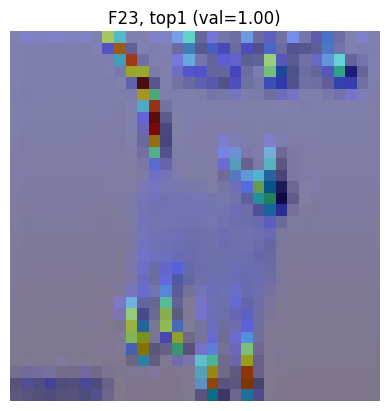

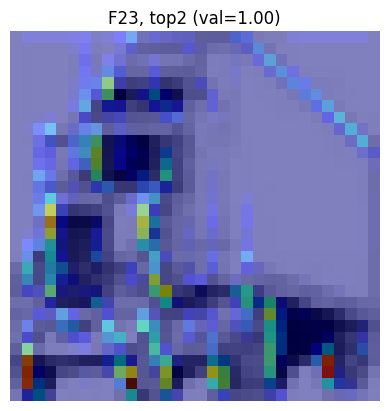

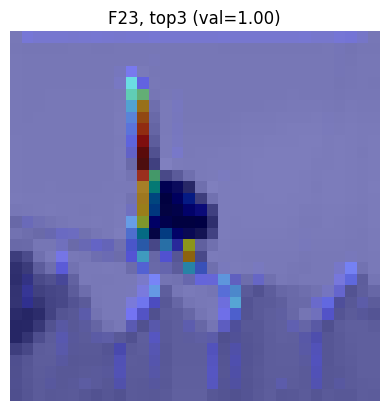

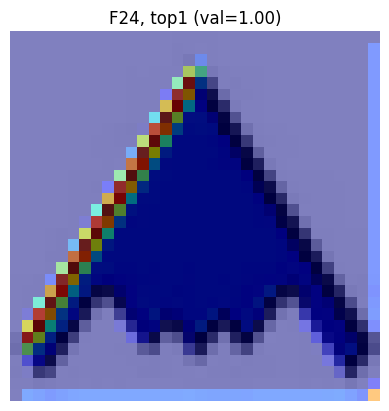

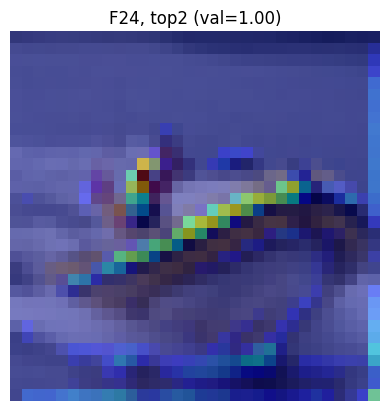

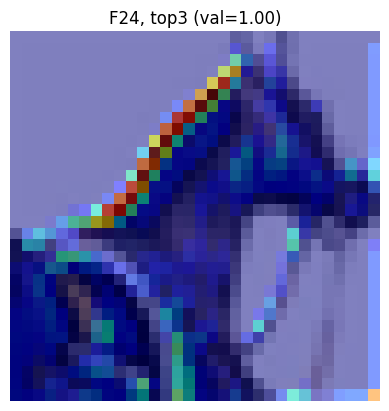

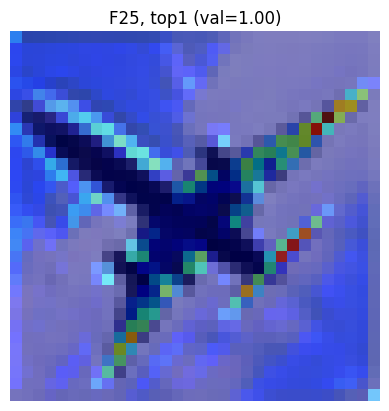

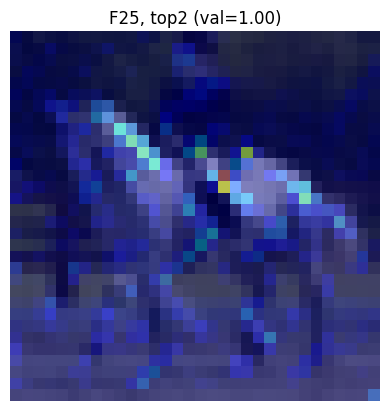

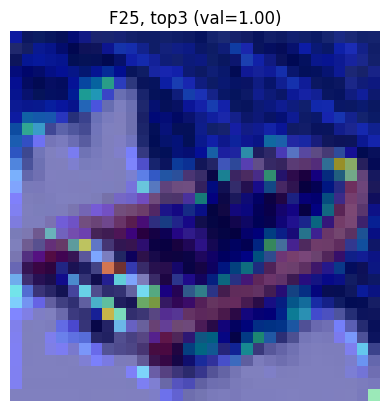

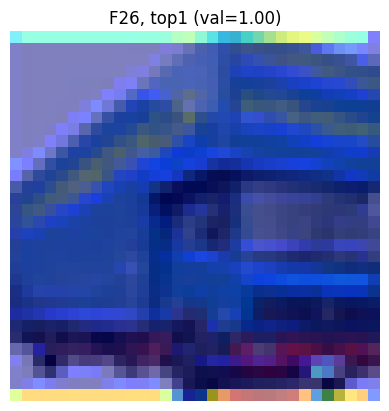

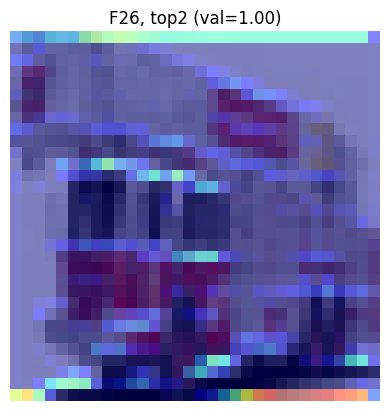

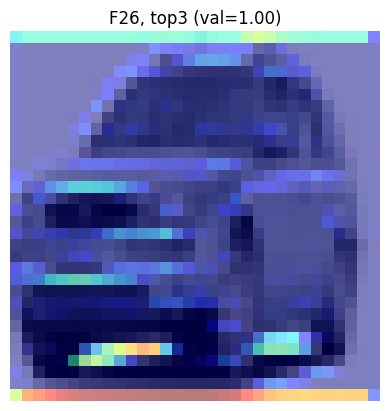

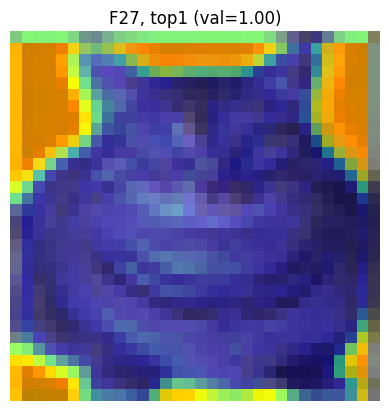

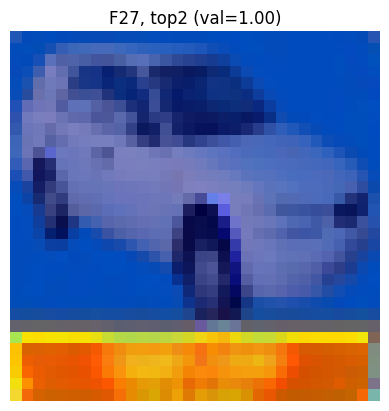

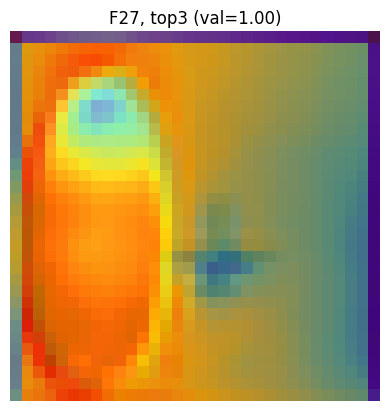

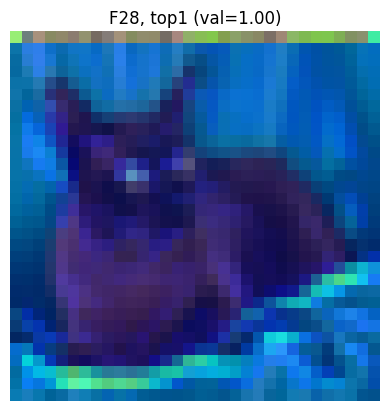

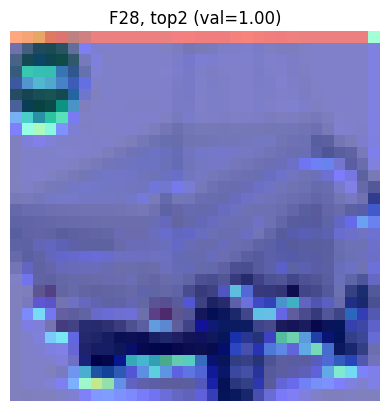

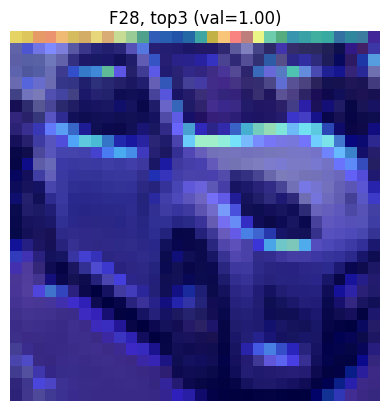

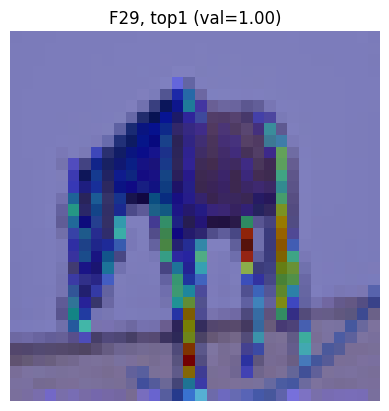

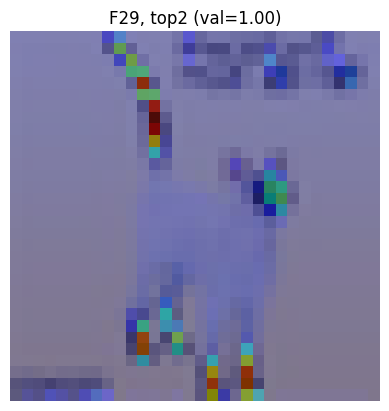

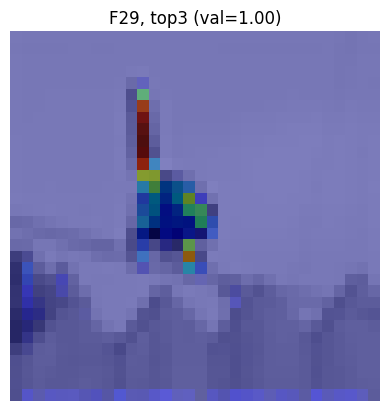

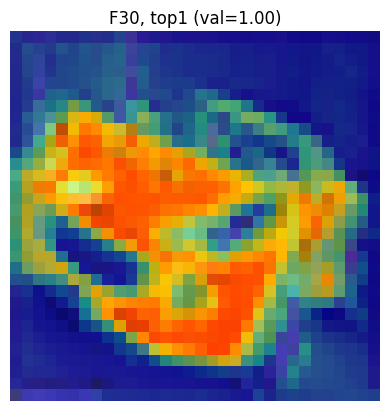

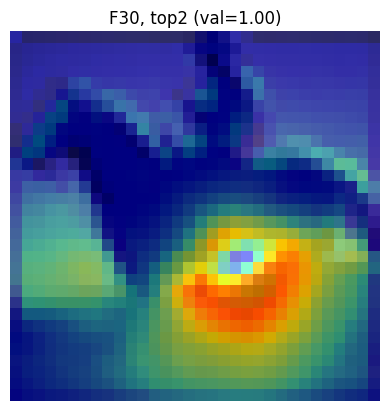

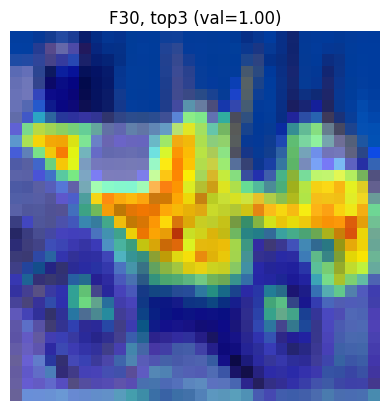

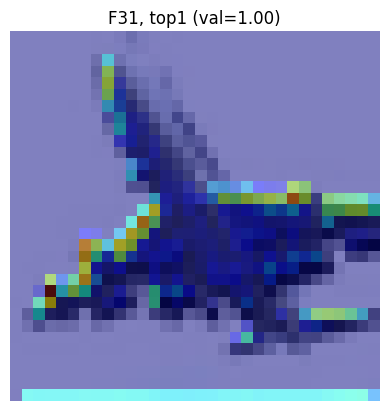

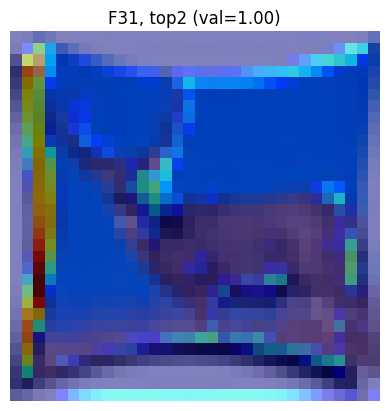

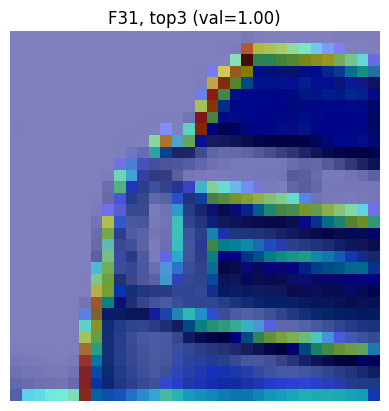

In [23]:
eval_loader = DataLoader(train_data, batch_size=128, shuffle=False)

# ------------------------------------------
# 1️⃣ Ensure Model and Data Are on MPS
# ------------------------------------------
model1.to("mps")  # Move model to MPS

activation = {}  # Dictionary to store activations

def hook_fn(module, input, output):
    # Store activations from relu1 (post-ReLU of cv1) on MPS
    activation["selected_layer"] = output.detach().to("mps")

# Register the hook on relu1
selected_layer = model1.relu1
hook = selected_layer.register_forward_hook(hook_fn)

# Number of top images per filter to keep
TOP_K = 3
num_filters = model1.cv1.out_channels  # Expected number of filters in cv1
topk_per_filter = [[] for _ in range(num_filters)]

# ------------------------------------------
# 2️⃣ Forward Pass & Gather Top-K Activations
# ------------------------------------------
model1.eval()

with t.no_grad():  # Disable gradient tracking
    for batch_idx, (images, _) in enumerate(tqdm(eval_loader, desc="Processing")):
        images = images.to("mps")  # Move images to MPS first
        _ = model1(images)  # Run forward pass → hook stores activations

        # Validate stored activations before proceeding
        if "selected_layer" not in activation or activation["selected_layer"] is None:
            print(f"⚠️ WARNING: No activation stored for batch {batch_idx}, skipping...")
            continue  # Skip this batch

        # Get activation shape
        acts = activation["selected_layer"]
        B, F_, H_act, W_act = acts.shape

        # Reinitialize top-k structure if necessary
        if len(topk_per_filter) != F_:
            topk_per_filter = [[] for _ in range(F_)]

        # For each image in the batch
        for b in range(B):
            img_tensor = images[b].cpu()
            img_np = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
            H_in, W_in = img_np.shape[:2]

            # For each filter i
            for i in range(F_):
                filter_map = acts[b, i, ...]  # (H_act, W_act)

                # Normalize activation map instead of thresholding
                filter_map = (filter_map - filter_map.min()) / (filter_map.max() - filter_map.min() + 1e-5)

                # Upsample activation map to match input image size
                filter_map_4d = filter_map.unsqueeze(0).unsqueeze(0)
                upsampled_map = t.nn.functional.interpolate(filter_map_4d, size=(H_in, W_in), 
                                                            mode='bilinear', align_corners=False)
                upsampled_map = upsampled_map.squeeze(0).squeeze(0).cpu().numpy()  # (H_in, W_in)

                max_val = upsampled_map.max()  # Get max value after upsampling

                # Store only the top-K activations for this filter
                if len(topk_per_filter[i]) < TOP_K or max_val > topk_per_filter[i][0][0]:
                    topk_per_filter[i].append((max_val, upsampled_map, img_np))
                    topk_per_filter[i].sort(key=lambda x: x[0])  # Sort by activation value
                    if len(topk_per_filter[i]) > TOP_K:
                        topk_per_filter[i].pop(0)  # Keep only top-K

        # 🛠 Free memory after processing the batch
        activation["selected_layer"] = None  # Prevent cache buildup

# ------------------------------------------
# 3️⃣ Visualization: Overlay Heatmap on Original Image
# ------------------------------------------
for i in range(len(topk_per_filter)):
    records = sorted(topk_per_filter[i], key=lambda x: x[0], reverse=True)  # Sort descending
    
    for rank in range(TOP_K):
        if rank < len(records):
            val, upsampled_map, img_np = records[rank]

            fig, ax = subplots()
            ax.imshow(img_np)  # Show original image
            ax.imshow(upsampled_map, cmap='jet', alpha=0.5)  # Overlay heatmap

            ax.set_title(f"F{i}, top{rank+1} (val={val:.2f})")
            axis("off")
            show()


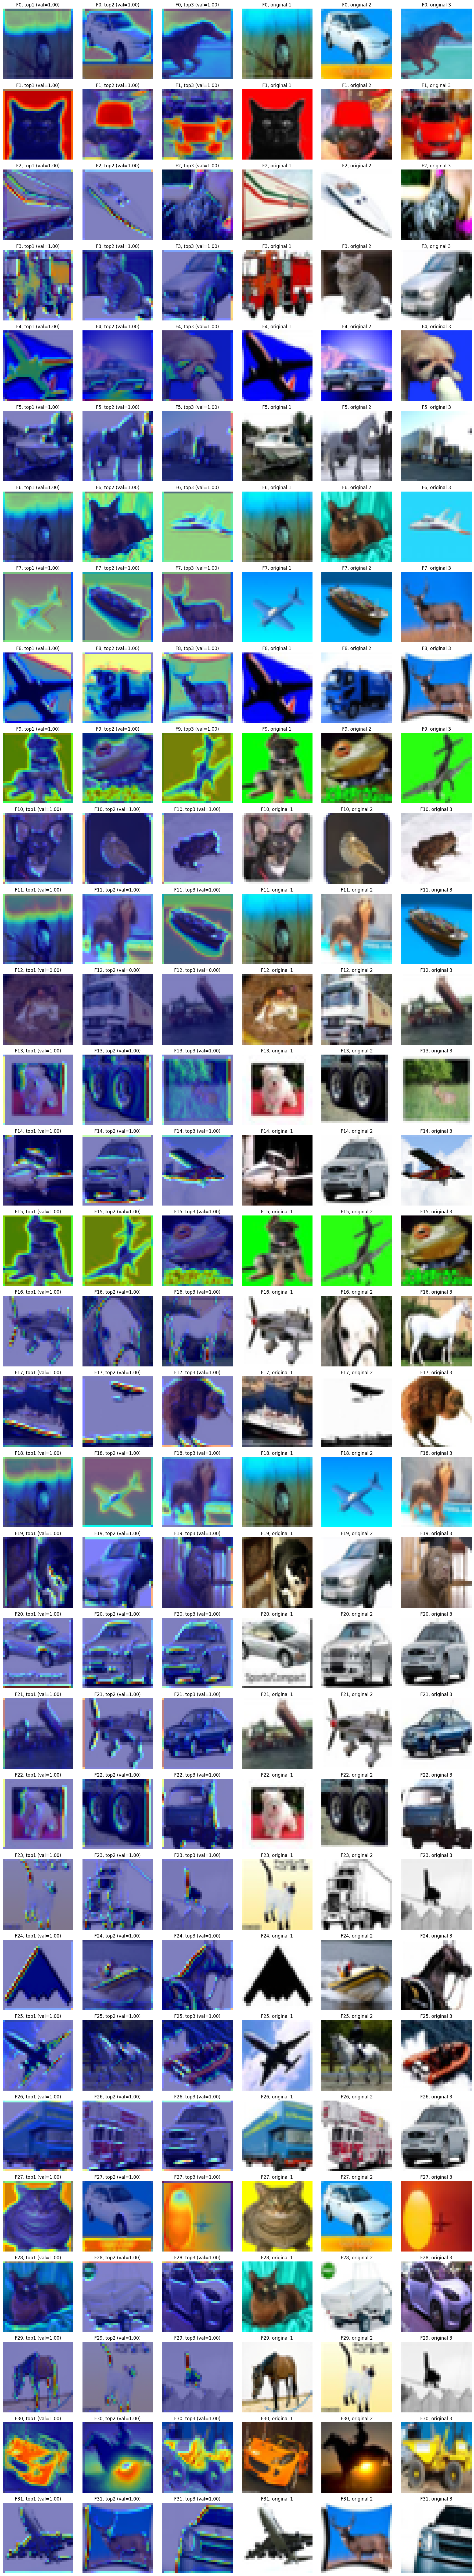

In [ ]:
fig, axes = subplots(num_filters, TOP_K + TOP_K, figsize=(3 * (TOP_K + TOP_K), 3 * num_filters))

for i in range(num_filters):
    records = sorted(topk_per_filter[i], key=lambda x: x[0], reverse=True)  # Sort descending

    for rank in range(TOP_K):
        ax_overlay = axes[i, rank]  # First half: overlayed images
        ax_original = axes[i, rank + TOP_K]  # Second half: uncovered images

        if rank < len(records):
            val, upsampled_map, img_np = records[rank]

            
            ax_overlay.imshow(img_np)  # Original image
            ax_overlay.imshow(upsampled_map, cmap='jet', alpha=0.5)  # Overlay heatmap
            ax_overlay.set_title(f"F{i}, top{rank+1} (val={val:.2f})")
            ax_overlay.axis("off")


            ax_original.imshow(img_np)  # Just the raw image
            ax_original.set_title(f"F{i}, original {rank+1}")
            ax_original.axis("off")

tight_layout()
show();

## $CV2~post-ReLU$

Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Processing: 100%|██████████| 391/391 [2:19:40<00:00, 21.43s/it]  


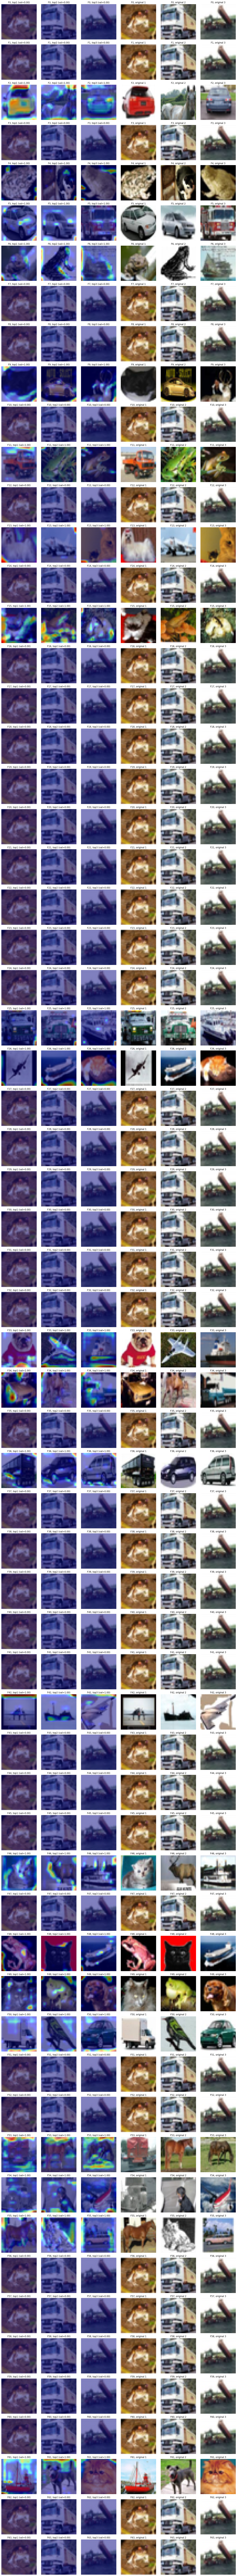

In [28]:
# ------------------------------------------
# 1️⃣ Ensure Model and Data Are on MPS
# ------------------------------------------
model1.to("mps")  # Move model to MPS

activation = {}  # Dictionary to store activations

def hook_fn(module, input, output):
    # Store activations from relu2 (post-ReLU of cv2) on MPS
    activation["selected_layer"] = output.detach().to("mps")

# Register the hook on relu2
selected_layer = model1.relu2
hook = selected_layer.register_forward_hook(hook_fn)

# Number of top images per filter to keep
TOP_K = 3
num_filters = model1.cv2.out_channels  # Expected number of filters in cv2
topk_per_filter = [[] for _ in range(num_filters)]

# ------------------------------------------
# 2️⃣ Forward Pass & Gather Top-K Activations
# ------------------------------------------
model1.eval()

with t.no_grad():  # Disable gradient tracking
    for batch_idx, (images, _) in enumerate(tqdm(eval_loader, desc="Processing")):
        images = images.to("mps")  # Move images to MPS first
        _ = model1(images)  # Run forward pass → hook stores activations

        # Validate stored activations before proceeding
        if "selected_layer" not in activation or activation["selected_layer"] is None:
            print(f"⚠️ WARNING: No activation stored for batch {batch_idx}, skipping...")
            continue  # Skip this batch

        # Get activation shape
        acts = activation["selected_layer"]
        B, F_, H_act, W_act = acts.shape

        # Reinitialize top-k structure if necessary
        if len(topk_per_filter) != F_:
            topk_per_filter = [[] for _ in range(F_)]

        # For each image in the batch
        for b in range(B):
            img_tensor = images[b].cpu()
            img_np = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
            H_in, W_in = img_np.shape[:2]

            # For each filter i
            for i in range(F_):
                filter_map = acts[b, i, ...]  # (H_act, W_act)

                # Normalize activation map instead of thresholding
                filter_map = (filter_map - filter_map.min()) / (filter_map.max() - filter_map.min() + 1e-5)

                # Upsample activation map to match input image size
                filter_map_4d = filter_map.unsqueeze(0).unsqueeze(0)
                upsampled_map = t.nn.functional.interpolate(filter_map_4d, size=(H_in, W_in), 
                                                            mode='bilinear', align_corners=False)
                upsampled_map = upsampled_map.squeeze(0).squeeze(0).cpu().numpy()  # (H_in, W_in)

                max_val = upsampled_map.max()  # Get max value after upsampling

                # Store only the top-K activations for this filter
                if len(topk_per_filter[i]) < TOP_K or max_val > topk_per_filter[i][0][0]:
                    topk_per_filter[i].append((max_val, upsampled_map, img_np))
                    topk_per_filter[i].sort(key=lambda x: x[0])  # Sort by activation value
                    if len(topk_per_filter[i]) > TOP_K:
                        topk_per_filter[i].pop(0)  # Keep only top-K

        # 🛠 Free memory after processing the batch
        activation["selected_layer"] = None  # Prevent cache buildup

# ------------------------------------------
# 3️⃣ Visualization: Overlay Heatmap and Original Images
# ------------------------------------------
# Define new grid size: (num_filters, TOP_K + TOP_K)
fig, axes = subplots(num_filters, TOP_K + TOP_K, figsize=(3 * (TOP_K + TOP_K), 3 * num_filters))

for i in range(num_filters):
    records = sorted(topk_per_filter[i], key=lambda x: x[0], reverse=True)  # Sort descending

    for rank in range(TOP_K):
        ax_overlay = axes[i, rank]  # First half: overlayed images
        ax_original = axes[i, rank + TOP_K]  # Second half: uncovered images

        if rank < len(records):
            val, upsampled_map, img_np = records[rank]

            # 🔥 1️⃣ Heatmap Overlay
            ax_overlay.imshow(img_np)  # Original image
            ax_overlay.imshow(upsampled_map, cmap='jet', alpha=0.5)  # Overlay heatmap
            ax_overlay.set_title(f"F{i}, top{rank+1} (val={val:.2f})")
            ax_overlay.axis("off")

            # 🎨 2️⃣ Uncovered Original Image
            ax_original.imshow(img_np)  # Just the raw image
            ax_original.set_title(f"F{i}, original {rank+1}")
            ax_original.axis("off")

# Improve layout
tight_layout()
show();

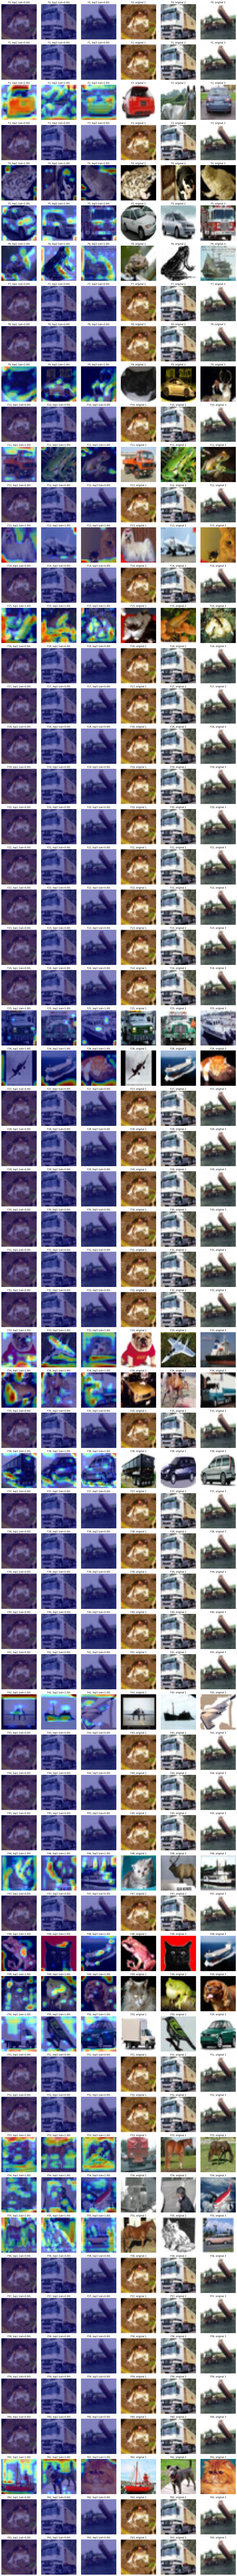

In [41]:
fig, axes = subplots(num_filters, TOP_K + TOP_K, figsize=(3 * (TOP_K + TOP_K), 3 * num_filters))

for i in range(num_filters):
    records = sorted(topk_per_filter[i], key=lambda x: x[0], reverse=True)  # Sort descending

    for rank in range(TOP_K):
        ax_overlay = axes[i, rank]  # First half: overlayed images
        ax_original = axes[i, rank + TOP_K]  # Second half: uncovered images

        if rank < len(records):
            val, upsampled_map, img_np = records[rank]
            
            upsampled_map = upsampled_map ** 0.5
            
            # 🔥 1️⃣ Heatmap Overlay
            ax_overlay.imshow(img_np)  # Original image
            ax_overlay.imshow(upsampled_map, cmap='jet', alpha=0.5, vmin=0, vmax=1)  # Overlay heatmap
            ax_overlay.set_title(f"F{i}, top{rank+1} (val={val:.2f})")
            ax_overlay.axis("off")

            # 🎨 2️⃣ Uncovered Original Image
            ax_original.imshow(img_np)  # Just the raw image
            ax_original.set_title(f"F{i}, original {rank+1}")
            ax_original.axis("off")

# Improve layout
tight_layout()
show();

## $CV3~post-ReLU$

In [ ]:
# ------------------------------------------
# 1️⃣ Ensure Model and Data Are on MPS
# ------------------------------------------
model1.to("mps")  # Move model to MPS

activation = {}  # Dictionary to store activations

def hook_fn(module, input, output):
    # Store activations from relu2 (post-ReLU of cv2) on MPS
    activation["selected_layer"] = output.detach().to("mps")

# Register the hook on relu2
selected_layer = model1.relu3
hook = selected_layer.register_forward_hook(hook_fn)

# Number of top images per filter to keep
TOP_K = 3
num_filters = model1.cv3.out_channels  # Expected number of filters in cv2
topk_per_filter = [[] for _ in range(num_filters)]

# ------------------------------------------
# 2️⃣ Forward Pass & Gather Top-K Activations
# ------------------------------------------
model1.eval()

with t.no_grad():  # Disable gradient tracking
    for batch_idx, (images, _) in enumerate(tqdm(eval_loader, desc="Processing")):
        images = images.to("mps")  # Move images to MPS first
        _ = model1(images)  # Run forward pass → hook stores activations

        # Validate stored activations before proceeding
        if "selected_layer" not in activation or activation["selected_layer"] is None:
            print(f"⚠️ WARNING: No activation stored for batch {batch_idx}, skipping...")
            continue  # Skip this batch

        # Get activation shape
        acts = activation["selected_layer"]
        B, F_, H_act, W_act = acts.shape

        # Reinitialize top-k structure if necessary
        if len(topk_per_filter) != F_:
            topk_per_filter = [[] for _ in range(F_)]

        # For each image in the batch
        for b in range(B):
            img_tensor = images[b].cpu()
            img_np = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
            H_in, W_in = img_np.shape[:2]

            # For each filter i
            for i in range(F_):
                filter_map = acts[b, i, ...]  # (H_act, W_act)

                # Normalize activation map instead of thresholding
                filter_map = (filter_map - filter_map.min()) / (filter_map.max() - filter_map.min() + 1e-5)

                # Upsample activation map to match input image size
                filter_map_4d = filter_map.unsqueeze(0).unsqueeze(0)
                upsampled_map = t.nn.functional.interpolate(filter_map_4d, size=(H_in, W_in), 
                                                            mode='bilinear', align_corners=False)
                upsampled_map = upsampled_map.squeeze(0).squeeze(0).cpu().numpy()  # (H_in, W_in)

                max_val = upsampled_map.max()  # Get max value after upsampling

                # Store only the top-K activations for this filter
                if len(topk_per_filter[i]) < TOP_K or max_val > topk_per_filter[i][0][0]:
                    topk_per_filter[i].append((max_val, upsampled_map, img_np))
                    topk_per_filter[i].sort(key=lambda x: x[0])  # Sort by activation value
                    if len(topk_per_filter[i]) > TOP_K:
                        topk_per_filter[i].pop(0)  # Keep only top-K

        # 🛠 Free memory after processing the batch
        activation["selected_layer"] = None  # Prevent cache buildup

# ------------------------------------------
# 3️⃣ Visualization: Overlay Heatmap and Original Images
# ------------------------------------------
# Define new grid size: (num_filters, TOP_K + TOP_K)
fig, axes = subplots(num_filters, TOP_K + TOP_K, figsize=(3 * (TOP_K + TOP_K), 3 * num_filters))

for i in range(num_filters):
    records = sorted(topk_per_filter[i], key=lambda x: x[0], reverse=True)  # Sort descending

    for rank in range(TOP_K):
        ax_overlay = axes[i, rank]  # First half: overlayed images
        ax_original = axes[i, rank + TOP_K]  # Second half: uncovered images

        if rank < len(records):
            val, upsampled_map, img_np = records[rank]

            # 🔥 1️⃣ Heatmap Overlay
            ax_overlay.imshow(img_np)  # Original image
            ax_overlay.imshow(upsampled_map, cmap='jet', alpha=0.5)  # Overlay heatmap
            ax_overlay.set_title(f"F{i}, top{rank+1} (val={val:.2f})")
            ax_overlay.axis("off")

            # 🎨 2️⃣ Uncovered Original Image
            ax_original.imshow(img_np)  # Just the raw image
            ax_original.set_title(f"F{i}, original {rank+1}")
            ax_original.axis("off")

# Improve layout
tight_layout()
show();

In [43]:
 t.mps.empty_cache()